# Task 1: ECG Heartbeat Categorization 

Segmented and Preprocessed ECG Signals for Heartbeat Classification

1) Download the dataset from the ECG Heartbeat Categorization Dataset:
https://www.kaggle.com/datasets/shayanfazeli/heartbeat
2) Unzip the archive.zip file
3) Rename the folder archive as ecg_dataset and place it in the root of the git repository

References: 
ECG Heartbeat Classification: A Deep Transferable Representation: https://arxiv.org/pdf/1805.00794.pdf

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
#import lightgbm as lgb

# The PTB Diagnostic ECG Database
Number of Samples: 14552
Number of Categories: 2
Sampling Frequency: 125Hz
Data Source: Physionet's PTB Diagnostic Database
ECG lead II re-sampled to the sampling frequency of 125Hz as the input (from ECG Heartbeat Classification: A Deep Transferable Representation)
Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.
The final element of each row denotes the class to which that example belongs.

The shape of the normal dataframe is :  (4046, 188)
Class :  0.0
The shape of the abnormal dataframe is :  (10506, 188)
Class :  1.0
The last time value is :  1488.0


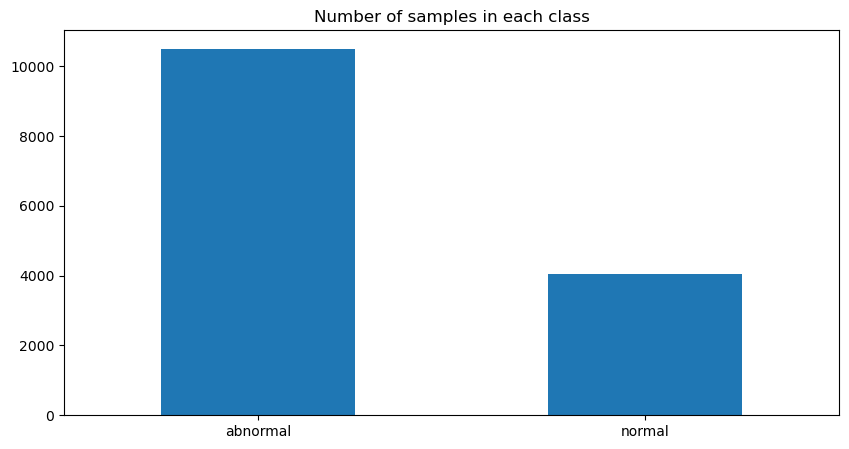

In [2]:
#df_ptbd_normal = pd.read_csv("../ecg_dataset/ptbdb_normal.csv", header = None)
#df_ptbd_abnormal = pd.read_csv("../ecg_dataset/ptbdb_abnormal.csv", header = None)

df_ptbd_normal = pd.read_csv('C:/Users/Justin/Documents/LLNL/Data/Task1/ecg_dataset/ptbdb_normal.csv', header=None)
df_ptbd_abnormal = pd.read_csv('C:/Users/Justin/Documents/LLNL/Data/Task1/ecg_dataset/ptbdb_abnormal.csv', header=None)

# print shapes of the dataframes
print("The shape of the normal dataframe is : ", df_ptbd_normal.shape)
# print one example of the last column
print("Class : ", df_ptbd_normal.iloc[:, -1][0])
print("The shape of the abnormal dataframe is : ", df_ptbd_abnormal.shape)
# print one example of the last column
print("Class : ", df_ptbd_abnormal.iloc[:, -1][0])

# classes are 0 (normal) and 1 (abnormal)
classes_names = {0 : "normal",
                 1 : "abnormal"}

# get the number of columns in the dataframe
# the last column is the label/class
num_cols = df_ptbd_normal.shape[1] - 1
# the signal was resampled at frequency of 125Hz as the input
# compute the time vector
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000
# print last time value
print("The last time value is : ", time[-1])

# for the first "num_cols" and the time steps as column names
df_ptbd_normal.columns = list(time) + ["label"]
df_ptbd_abnormal.columns = list(time) + ["label"]

# concatenate the two dataframes
df_ptbd = pd.concat([df_ptbd_normal, df_ptbd_abnormal], axis = 0)

# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class
counts = df_ptbd["label"].value_counts()
# substitute the class names: 0.0 -> normal, 1.0 -> abnormal
counts.index = counts.index.map(classes_names)
# create a figure
plt.figure(figsize = (10, 5))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 0)
plt.title("Number of samples in each class")
plt.show()

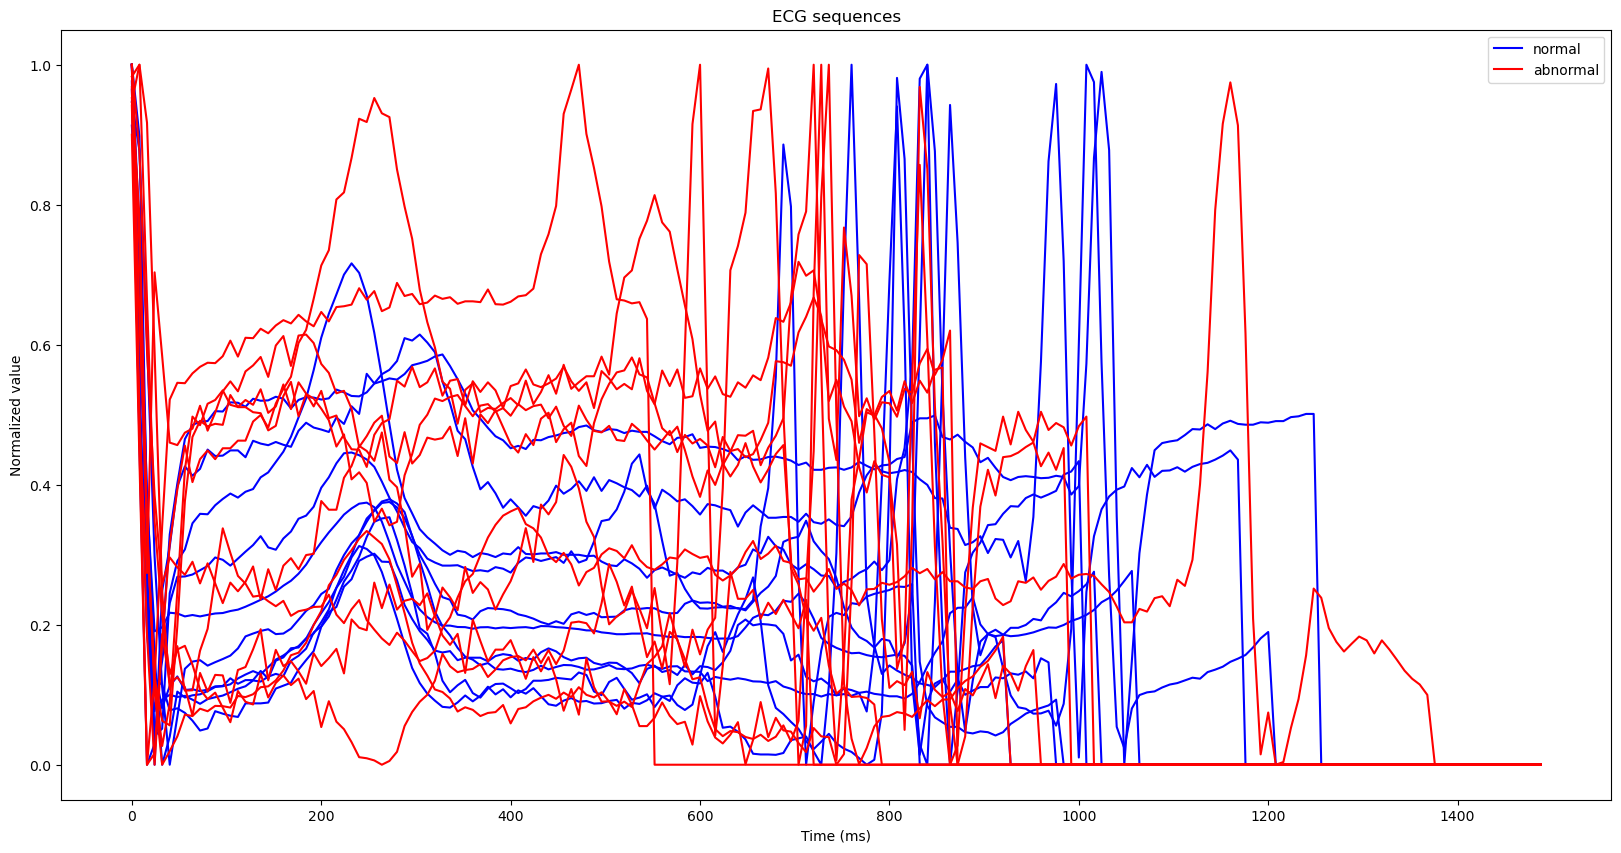

In [3]:
# plot a a row of the dataframe
# select 10 random sequences with class 0 (normal) and 10 with class 1 (abnormal)
df_ptbd_normal = df_ptbd[df_ptbd["label"] == 0].sample(10)
df_ptbd_abnormal = df_ptbd[df_ptbd["label"] == 1].sample(10)

# create a figure
plt.figure(figsize = (20, 10))
# plot againts the column names (time)
# plot the normal sequences
for i in range(df_ptbd_normal.shape[0]):
    if i == 0:
        plt.plot(df_ptbd_normal.columns[:-1], df_ptbd_normal.iloc[i, :-1], color = "blue", label = "normal")
    else:
        plt.plot(df_ptbd_normal.columns[:-1], df_ptbd_normal.iloc[i, :-1],color = "blue")
# plot the abnormal sequences
for i in range(df_ptbd_abnormal.shape[0]):
    if i == 0:
        plt.plot(df_ptbd_abnormal.columns[:-1], df_ptbd_abnormal.iloc[i, :-1], color = "red", label = "abnormal")
    else:
        plt.plot(df_ptbd_abnormal.columns[:-1], df_ptbd_abnormal.iloc[i, :-1], color = "red")
# create a legend for the plot, blue for normal and red for abnormal
plt.legend()
# set the title
plt.title("ECG sequences")
# y lable is "Normalized value"
plt.ylabel("Normalized value")
# x label is "Time (ms)"
plt.xlabel("Time (ms)")
# show the plot
plt.show()
# close
plt.close()

In [4]:
# Convert o numpy array 
X = df_ptbd.to_numpy()
XX = X[:,:-1]
Y = X[:,-1]
print("Input data dimensions:", XX.shape)
print("Input label dimensions:", Y.shape)

Input data dimensions: (14552, 187)
Input label dimensions: (14552,)


# Random Forest 

In [6]:
# Random forest with stratified k-fold cross validation and grid search 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(XX, Y, test_size=0.3, stratify=Y, random_state=42)

# Create Random Forest classifier
rf = RandomForestClassifier()

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees [100, 200, 300]
    'max_depth': [None, 2],  # Maximum depth of each tree [None, 5, 10],
    'min_samples_split': [2, 4],  # Minimum number of samples required to split an internal node [2, 5, 10],
    'min_samples_leaf': [1, 2],  # Minimum number of samples required to be at a leaf node [1, 2, 4]
    'max_features': ['sqrt', 'log2']  # Number of features to -consider when looking for the best split ['sqrt', 'log2'] 
}

# Perform grid search with stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model and its performance
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_

# Evaluate the best model on the test set
test_score = best_model.score(X_test, y_test)

# Print the best hyperparameters and scores
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", best_score)
print("Test Accuracy:", test_score)

# Best Hyperparameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, ...
# 'n_estimators': 100}


Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.9685841856951598
Test Accuracy: 0.9677049931287219


In [7]:
# %% Random Forest (no cross validation)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(XX, Y, test_size=0.2, random_state=41)

# Create a Random Forest Classifier
classifier = RandomForestClassifier()

# Fit the classifier to the training data
classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
np.sum(np.abs(y_test - y_pred))

Accuracy: 0.970113363105462


87.0

In [10]:
# %% random forest with k-fold validation 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Define the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100)

# Create k-fold cross-validator
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation
accuracies = []
for train_index, test_index in kfold.split(XX, Y):
    X_train, X_test = XX[train_index], XX[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # Fit the model on the training data
    rf_model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = rf_model.predict(X_test)
    
    # Calculate accuracy on the test data
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

RF_accuracies_kfold = accuracies
# Calculate and print the average accuracy across folds
avg_accuracy = sum(accuracies) / len(accuracies)
print("Average Accuracy: {:.2f}%".format(avg_accuracy * 100))

Average Accuracy: 97.42%


In [11]:
#%% Random Forest with Straified k - fold cross validation 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Create the Random Forest classifier
rf_classifier = RandomForestClassifier(max_depth= None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=200)

# Set the number of cross-validation folds
k_folds = 10

# Create the stratified cross-validation object
stratified_kfold = StratifiedKFold(n_splits=k_folds)

# Perform cross-validation
scores = cross_val_score(rf_classifier, XX, Y, cv=stratified_kfold)

# Print the accuracy for each fold
for fold, score in enumerate(scores, 1):
    print(f"Fold {fold}: {score:.4f}")

RF_accuracies_skfold = scores
# Calculate and print the mean accuracy across all folds
mean_accuracy = scores.mean()
print(f"Mean Accuracy: {mean_accuracy:.4f}")

Fold 1: 0.9684
Fold 2: 0.9705
Fold 3: 0.9821
Fold 4: 0.9677
Fold 5: 0.9732
Fold 6: 0.9739
Fold 7: 0.9766
Fold 8: 0.9835
Fold 9: 0.9698
Fold 10: 0.9739
Mean Accuracy: 0.9740


In [13]:
# %% SVM with grid search and k-fold validation 
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(XX, Y, test_size=0.2, random_state=42)

# Define the SVM model
svm_model = SVC()

# Define the hyperparameter grid
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

# Create the grid search object
grid_search = GridSearchCV(svm_model, param_grid, cv=StratifiedKFold(n_splits=5))

# Perform grid search and cross-validation
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Print the best parameters
print("Best Parameters:", best_params)

Accuracy: 95.88%
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [16]:
# %% SVM with stratified k-fold validation 
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Define the SVM model
svm_model = SVC(C=10, gamma='scale', kernel='rbf')

# Create stratified k-fold cross-validator
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation
accuracies = []
for train_index, test_index in kfold.split(XX, Y):
    X_train, X_test = XX[train_index], XX[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # Fit the model on the training data
    svm_model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = svm_model.predict(X_test)
    
    # Calculate accuracy on the test data
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

SVM_accuracies_skfold = accuracies
# Calculate and print the average accuracy across folds
avg_accuracy = sum(accuracies) / len(accuracies)
print("Average Accuracy: {:.2f}%".format(avg_accuracy * 100))


Average Accuracy: 96.03%


In [17]:
# %% SVM with regular k-fold validation 
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Define the SVM model
svm_model = SVC(C=10, gamma='scale', kernel='rbf')

# Create k-fold cross-validator
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation
accuracies = []
for train_index, test_index in kfold.split(XX, Y):
    X_train, X_test = XX[train_index], XX[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # Fit the model on the training data
    svm_model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = svm_model.predict(X_test)
    
    # Calculate accuracy on the test data
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

SVM_accuracies_kfold = accuracies
# Calculate and print the average accuracy across folds
avg_accuracy = sum(accuracies) / len(accuracies)
print("Average Accuracy: {:.2f}%".format(avg_accuracy * 100))

Average Accuracy: 95.97%


In [18]:
# %% KNN Grid search 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Load the Iris dataset
#data = load_iris()
#X = data.data
#y = data.target

# Define the parameter grid for grid search
param_grid = {
    'n_neighbors': [1,3,5],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Create a KNN classifier
knn = KNeighborsClassifier()

# Perform grid search
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(XX, Y)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Best parameters: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Best score: 0.9679769944788166


In [20]:
# %% KNN cross-fold validation 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
#from sklearn.datasets import load_iris

# Create a KNN classifier
knn = KNeighborsClassifier(n_neighbors=1, weights='uniform', metric='manhattan')

# Perform cross-validation
scores = cross_val_score(knn, XX, Y, cv=10)
KNN_accuracies_kfold = scores
#avg_accuracy = sum(scores) / len(scores)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean score:", scores.mean())



Cross-validation scores: [0.96016484 0.97321429 0.97594502 0.97113402 0.97113402 0.97113402
 0.97044674 0.96838488 0.96494845 0.96907216]
Mean score: 0.9695578433593898


In [22]:
# %% KNN stratified cross-fold validation 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
#from sklearn.datasets import load_iris

# Create a KNN classifier
knn = KNeighborsClassifier(n_neighbors=1, weights='uniform', metric='manhattan')

# Perform stratified cross-validation
cv = StratifiedKFold(n_splits=10)
scores = cross_val_score(knn, XX, Y, cv=cv)
KNN_accuracies_Skfold = scores
#avg_accuracy = sum(scores) / len(scores)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean score:", scores.mean())

Cross-validation scores: [0.96016484 0.97321429 0.97594502 0.97113402 0.97113402 0.97113402
 0.97044674 0.96838488 0.96494845 0.96907216]
Mean score: 0.9695578433593898


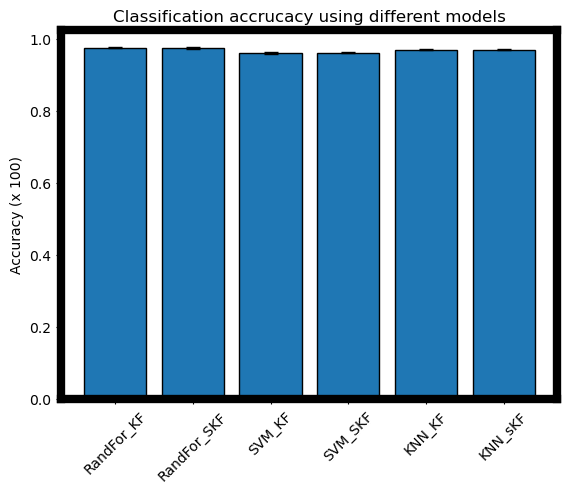

In [29]:
# %% SEM
RF_accuracies_kfold_sem = np.std(RF_accuracies_kfold) / np.sqrt(len(RF_accuracies_kfold))
RF_accuracies_Skfold_sem = np.std(RF_accuracies_skfold) / np.sqrt(len(RF_accuracies_skfold))
SVM_accuracies_kfold_sem = np.std(SVM_accuracies_kfold) / np.sqrt(len(SVM_accuracies_kfold))
SVM_accuracies_Skfold_sem = np.std(SVM_accuracies_skfold) / np.sqrt(len(SVM_accuracies_skfold))
KNN_accuracies_kfold_sem = np.std(KNN_accuracies_kfold) / np.sqrt(len(KNN_accuracies_kfold))
KNN_accuracies_Skfold_sem = np.std(KNN_accuracies_Skfold) / np.sqrt(len(KNN_accuracies_Skfold))

# %% Create a bar plot 
B = []
B.append(RF_accuracies_kfold)
B.append(RF_accuracies_skfold)
B.append(SVM_accuracies_kfold)
B.append(SVM_accuracies_skfold)
B.append(KNN_accuracies_kfold)
B.append(KNN_accuracies_Skfold)

B_ave = np.average(B,axis=1)
B_std = np.std(B,axis=1)
B_sem = B_std / (np.sqrt(np.size(B,axis=1)))

# Plotting
plt.bar(range(0, 6), B_ave, yerr=B_sem, capsize=5, edgecolor='black', linewidth=1)
plt.xticks(range(0, 6), ['RandFor_KF','RandFor_SKF', 'SVM_KF','SVM_SKF', 'KNN_KF', 'KNN_sKF'], rotation = 45)
plt.ylabel('Accuracy (x 100)')
plt.title('Classification accrucacy using different models')
plt.rcParams['axes.linewidth'] = 6

# Display the plot
plt.show()



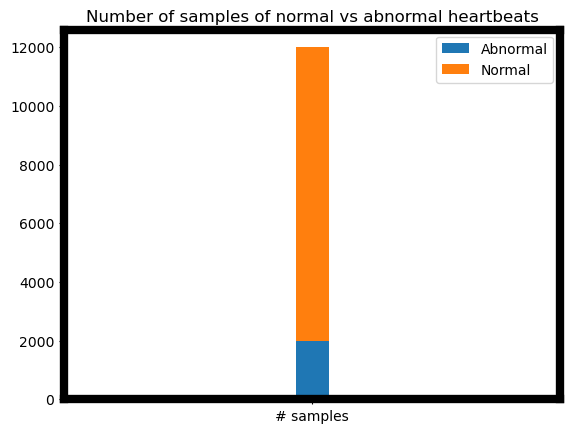

In [26]:
# %% Stacked barplot 
import matplotlib.pyplot as plt
import numpy as np

species = ('# samples',)
weight_counts = {
    "Abnormal": np.array([2000]),
    "Normal": np.array([10000]),
}

fig, ax = plt.subplots()
bottom = np.zeros(2)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, label=boolean, bottom=bottom)
    bottom += weight_count
ax.set_xlim([-6, 6])
ax.set_title("Number of samples of normal vs abnormal heartbeats")
ax.legend(loc="upper right")

plt.show()